In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_dataset_path = r"C:/Users/Rishabh Surana/Desktop/Skin Cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

val_dataset_path = r"C:/Users/Rishabh Surana/Desktop/Skin Cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

In [3]:
img_height = 224
img_width = 224
batch_size = 32
num_classes = 4

In [5]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load train data
train_data = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1428 images belonging to 4 classes.
Found 140 images belonging to 4 classes.


In [6]:
print("🔢 Total training images   :", train_data.samples)
print("🔍 Total validation images :", val_data.samples)
print("📂 Classes:", train_data.class_indices)

🔢 Total training images   : 1428
🔍 Total validation images : 140
📂 Classes: {'basal cell carcinoma': 0, 'melanoma': 1, 'nevus': 2, 'pigmented benign keratosis': 3}


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get labels from the generator
class_indices = train_data.class_indices
labels = train_data.classes  # Array of class labels

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


In [8]:
num_classes = len(train_data.class_indices)

In [9]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(img_height, img_width, 3)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax')
])


c:\Users\Rishabh Surana\Desktop\Skin Cancer\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Rishabh Surana\Desktop\Skin Cancer\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',         
    monitor='val_accuracy',          
    save_best_only=True,             
    mode='max',                      
    verbose=1
)

In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint]
)

c:\Users\Rishabh Surana\Desktop\Skin Cancer\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/45 ━━━━━━━━━━━━━━━━━━━━ 4:50 9s/step - accuracy: 0.3740 - loss: 3.0592

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
model = load_model('best_model.h5')
loss, accuracy = model.evaluate(val_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 0.6611 - loss: 1.7650


In [ ]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.6611 - loss: 1.7650
Validation Accuracy: 0.66


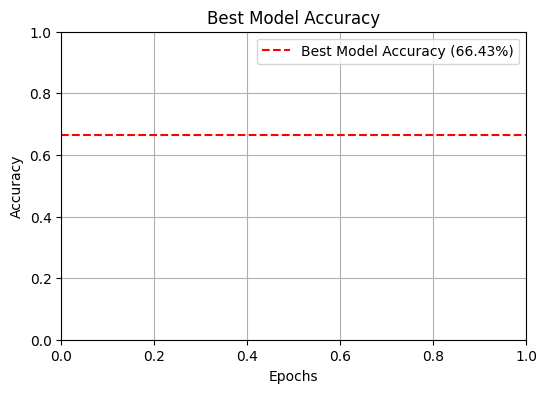

In [ ]:
import matplotlib.pyplot as plt

# Plot only the best model's accuracy as a horizontal line
plt.figure(figsize=(6, 4))
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Best Model Accuracy ({accuracy*100:.2f}%)')
plt.legend()
plt.title("Best Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

NameError: name 'history' is not defined

In [ ]:
val_data.reset()
y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=1)

# Only include classes that actually appear in y_true
unique_class_indices = np.unique(y_true)
index_to_class = {v: k for k, v in val_data.class_indices.items()}
target_names = [index_to_class[i] for i in unique_class_indices]

# Now this will work correctly
print(classification_report(y_true, y_pred, target_names=target_names))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step
                            precision    recall  f1-score   support

      basal cell carcinoma       0.83      0.83      0.83        35
                  melanoma       0.73      0.23      0.35        35
                     nevus       0.57      0.86      0.68        35
pigmented benign keratosis       0.63      0.74      0.68        35

                  accuracy                           0.66       140
                 macro avg       0.69      0.66      0.64       140
              weighted avg       0.69      0.66      0.64       140



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [ ]:
val_data.reset()
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(val_data.class_indices.keys())

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step


In [ ]:
val_data.reset()
y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=1)

# Map class index to label name
index_to_class = {v: k for k, v in val_data.class_indices.items()}

# Only include class labels that actually appear in y_true
unique_class_indices = np.unique(y_true)
class_labels = [index_to_class[i] for i in unique_class_indices]

# Print report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step
Classification Report:
                            precision    recall  f1-score   support

      basal cell carcinoma       0.83      0.83      0.83        35
                  melanoma       0.73      0.23      0.35        35
                     nevus       0.57      0.86      0.68        35
pigmented benign keratosis       0.63      0.74      0.68        35

                  accuracy                           0.66       140
                 macro avg       0.69      0.66      0.64       140
              weighted avg       0.69      0.66      0.64       140



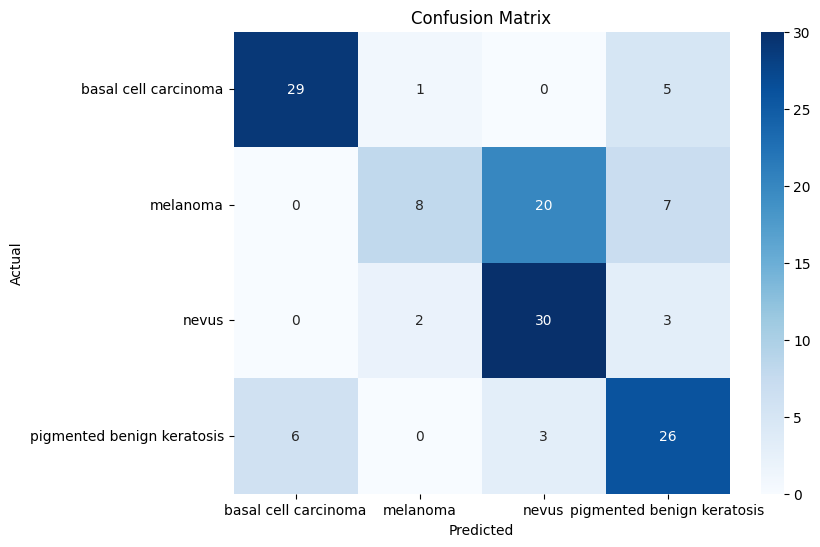

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.6643


In [ ]:
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"\nMacro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1-score: {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}, Weighted Recall: {recall_weighted:.4f}, Weighted F1-score: {f1_weighted:.4f}")


Macro Precision: 0.6890, Macro Recall: 0.6643, Macro F1-score: 0.6356
Weighted Precision: 0.6890, Weighted Recall: 0.6643, Weighted F1-score: 0.6356


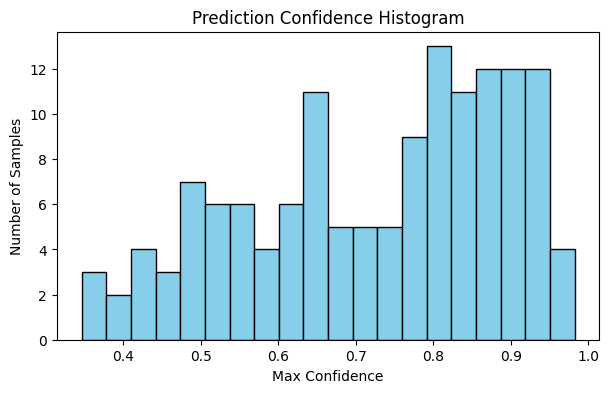

In [ ]:
confidences = np.max(y_pred_probs, axis=1)
plt.figure(figsize=(7, 4))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Max Confidence")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
# Assuming best model was at epoch 19, use index 18
best_epoch_index = 18

best_train_acc = history.history['accuracy'][best_epoch_index]
best_val_acc = history.history['val_accuracy'][best_epoch_index]

print("\n" + "="*40)
print("MODEL ACCURACIES")
print("="*40)
print(f"Training Accuracy   : {best_train_acc * 100:.4f} %")
print(f"Validation Accuracy : {best_val_acc * 100:.4f} %")
print("="*40)



MODEL ACCURACIES
Training Accuracy   : 70.5182 %
Validation Accuracy : 66.4286 %


In [ ]:
# from tensorflow.keras.preprocessing import image
# import numpy as np

# # Path to your local image
# img_path = "/content/drive/MyDrive/archive (1)/Split_smol/val/Melanoma/ISIC_0000166.jpg"  # change to your image path

# # Load and preprocess the image
# img = image.load_img(img_path, target_size=(img_height, img_width))
# img_array = image.img_to_array(img) / 255.0
# img_array = np.expand_dims(img_array, axis=0)

# # Predict using the model
# prediction = model.predict(img_array)
# predicted_class_idx = np.argmax(prediction)
# confidence = prediction[0][predicted_class_idx] * 100

# # Decode class index to label
# class_indices = train_data.class_indices
# inv_class_indices = {v: k for k, v in class_indices.items()}
# predicted_label = inv_class_indices[predicted_class_idx]

# # Print the result
# print(f"✅ Predicted Class: {predicted_label}")
# print(f"📊 Confidence: {confidence:.2f}%")

Found 1428 images belonging to 4 classes.
Found 140 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

🚀 Training Model: MobileNetV2


c:\Users\Rishabh Surana\Desktop\Skin Cancer\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.2575 - loss: 1.6968
Epoch 1: val_accuracy improved from -inf to 0.35714, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 841ms/step - accuracy: 0.2578 - loss: 1.6956 - val_accuracy: 0.3571 - val_loss: 1.3061
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.3715 - loss: 1.4562
Epoch 2: val_accuracy improved from 0.35714 to 0.45000, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 767ms/step - accuracy: 0.3715 - loss: 1.4554 - val_accuracy: 0.4500 - val_loss: 1.2195
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.4023 - loss: 1.3618
Epoch 3: val_accuracy improved from 0.45000 to 0.47857, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 749ms/step - accuracy: 0.4021 - loss: 1.3613 - val_accuracy: 0.4786 - val_loss: 1.1550
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.4254 - loss: 1.2807
Epoch 4: val_accuracy did not improve from 0.47857
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 741ms/step - accuracy: 0.4253 - loss: 1.2807 - val_accuracy: 0.4786 - val_loss: 1.1557
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.4615 - loss: 1.2291
Epoch 5: val_accuracy improved from 0.47857 to 0.50714, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 747ms/step - accuracy: 0.4613 - loss: 1.2293 - val_accuracy: 0.5071 - val_loss: 1.1027
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.4462 - loss: 1.1979
Epoch 6: val_accuracy did not improve from 0.50714
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 733ms/step - accuracy: 0.4471 - loss: 1.1974 - val_accuracy: 0.5071 - val_loss: 1.0811
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.5062 - loss: 1.1398
Epoch 7: val_accuracy did not improve from 0.50714
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 727ms/step - accuracy: 0.5061 - loss: 1.1400 - val_accuracy: 0.4929 - val_loss: 1.0888
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5025 - loss: 1.1532
Epoch 8: val_accuracy improved from 0.50714 to 0.54286, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 724ms/step - accuracy: 0.5029 - loss: 1.1525 - val_accuracy: 0.5429 - val_loss: 1.0618
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.5079 - loss: 1.1055
Epoch 9: val_accuracy did not improve from 0.54286
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 735ms/step - accuracy: 0.5081 - loss: 1.1052 - val_accuracy: 0.5286 - val_loss: 1.0457
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5239 - loss: 1.1077
Epoch 10: val_accuracy did not improve from 0.54286
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5240 - loss: 1.1075 - val_accuracy: 0.5071 - val_loss: 1.0487
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.5385 - loss: 1.0637
Epoch 11: val_accuracy did not improve from 0.54286
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 933ms/step - accuracy: 0.5382 - loss: 1.0640 - val_accuracy: 0.5071 - val_loss: 1.0297
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.5754 - loss: 1.0485
Epoch 12: val_accuracy did not i

45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 756ms/step - accuracy: 0.5751 - loss: 1.0162 - val_accuracy: 0.5500 - val_loss: 0.9750
Epoch 18/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5563 - loss: 1.0122
Epoch 18: val_accuracy improved from 0.55000 to 0.56429, saving model to MobileNetV2_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 760ms/step - accuracy: 0.5566 - loss: 1.0117 - val_accuracy: 0.5643 - val_loss: 0.9837
Epoch 19/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.6374 - loss: 0.9442
Epoch 19: val_accuracy did not improve from 0.56429
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 750ms/step - accuracy: 0.6372 - loss: 0.9446 - val_accuracy: 0.5357 - val_loss: 0.9694
Epoch 20/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6020 - loss: 0.9899
Epoch 20: val_accuracy did not improve from 0.56429
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 759ms/step - accuracy: 0.6021 - loss: 0.9896 - val_accuracy: 0.5429 - val_loss: 0.9444
Restoring model weights from the end of the best epoch: 20.
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/stepWARNING:tensorflow:5 out of the last 26 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E1A07AC5E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 743ms/step

📊 Classification Report for MobileNetV2:
                             precision    recall  f1-score   support

      basal cell carcinoma       0.59      0.83      0.69        35
                  melanoma       0.50      0.43      0.46        35
                     nevus       0.58      0.60      0.59        35
pigmented benign keratosis       0.44      0.31      0.37        35

                  accuracy                           0.54       140
                 macro avg       0.53      0.54      0.53       140
              weighted avg       0.53      0.54      0.53       140



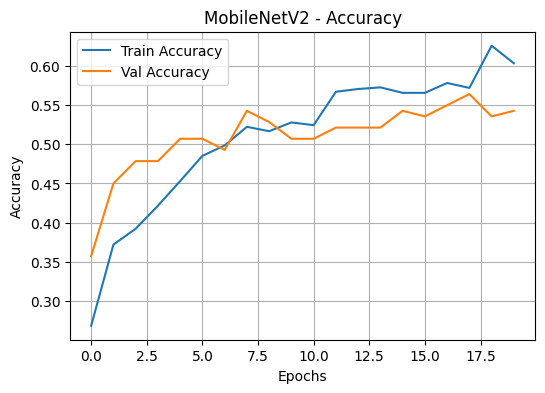


🚀 Training Model: EfficientNetB0
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2496 - loss: 1.4074
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to EfficientNetB0_best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2498 - loss: 1.4073 - val_accuracy: 0.2500 - val_loss: 1.3936
Epoch 2/20
 6/45 ━━━━━━━━━━━━━━━━━━━━ 19:16 30s/step - accuracy: 0.2119 - loss: 1.4336

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# ✅ DATA PATHS
train_path = "C:/Users/Rishabh Surana/Desktop/Skin Cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
val_path = "C:/Users/Rishabh Surana/Desktop/Skin Cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

results = []

img_height, img_width = 224, 224
batch_size = 32
epochs = 50

# ✅ DATA LOADERS
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=True)
val_data = val_gen.flow_from_directory(val_path, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

class_labels = list(train_data.class_indices.keys())
num_classes = len(class_labels)

# ✅ MODEL BUILDER
def build_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ MODELS TO COMPARE
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, DenseNet121, Xception
model_names = {
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "DenseNet121": DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
}

# ✅ LOOP THROUGH EACH MODEL
for name, base in model_names.items():
    print(f"\n🚀 Training Model: {name}")
    model = build_model(base)
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

    # Callbacks: EarlyStopping & ModelCheckpoint
    checkpoint_path = f"{name}_best_model.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks = [checkpoint, earlystop]
    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks)

    # ✅ Evaluation
    val_data.reset()
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes
    print(f"\n📊 Classification Report for {name}:\n", classification_report(y_true, y_pred, target_names=class_labels))
    
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(f"\n📊 Classification Report for {name}:\n", classification_report(y_true, y_pred, target_names=class_labels))

    # ✅ Accuracy Values
    final_train_acc = history.history['accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])

    # ✅ Append to results list
    results.append({
    'Model': name,
    'Train Accuracy (Final Epoch)': f"{final_train_acc:.4f}",
    'Best Val Accuracy': f"{best_val_acc:.4f}",
    'Precision': f"{report['weighted avg']['precision']:.4f}",
    'Recall': f"{report['weighted avg']['recall']:.4f}",
    'F1-Score': f"{report['weighted avg']['f1-score']:.4f}"
    })

    # ✅ Plot Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.show()


In [ ]:
# ✅ Display Comparison Table
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison Table:\n")
print(results_df.to_markdown(index=False))



NameError: name 'pd' is not defined


🚀 Training Model: MobileNetV2
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5719 - loss: 0.8790 - val_accuracy: 0.6750 - val_loss: 0.5459
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6037 - loss: 0.8116 - val_accuracy: 0.7500 - val_loss: 0.4988
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6104 - loss: 0.7170 - val_accuracy: 0.7750 - val_loss: 0.4662
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


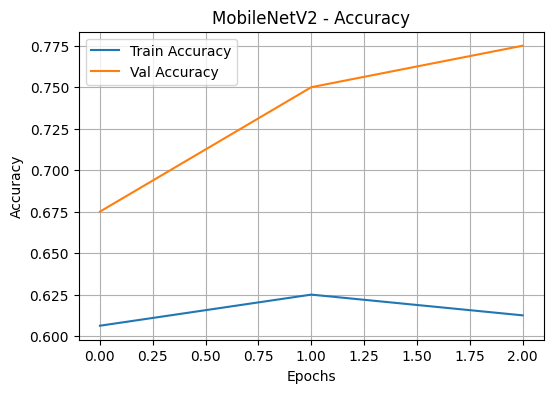

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
🔍 MobileNetV2 Prediction: Melanocytic nevus (82.56% confidence)

🚀 Training Model: EfficientNetB0
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.5214 - loss: 0.7080 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5428 - loss: 0.6760 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4648 - loss: 0.7074 - val_accuracy: 0.5000 - val_loss: 0.6935
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


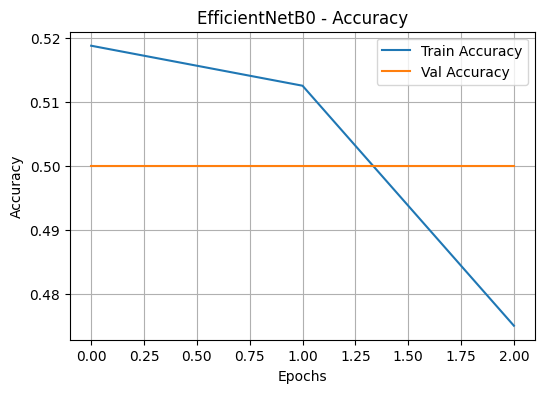

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 EfficientNetB0 Prediction: Dermatofibroma (51.09% confidence)

🚀 Training Model: ResNet50
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.4229 - loss: 0.9186 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5279 - loss: 0.7492 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.4787 - loss: 0.8011 - val_accuracy: 0.5000 - val_loss: 0.6947
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


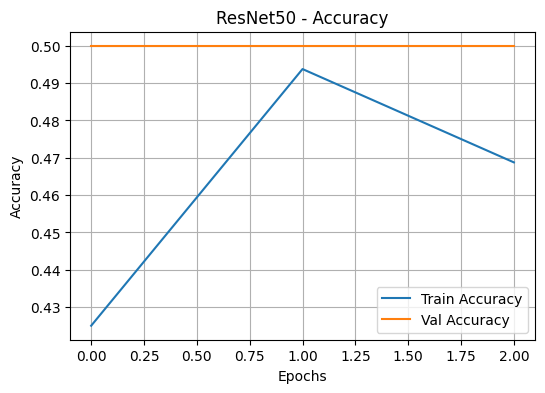

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 ResNet50 Prediction: Dermatofibroma (52.88% confidence)

🚀 Training Model: DenseNet121
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 10s/step - accuracy: 0.5417 - loss: 1.1488 - val_accuracy: 0.5000 - val_loss: 1.1637
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5581 - loss: 0.8762 - val_accuracy: 0.5750 - val_loss: 0.8421
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4863 - loss: 0.9080 - val_accuracy: 0.5500 - val_loss: 0.6860
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


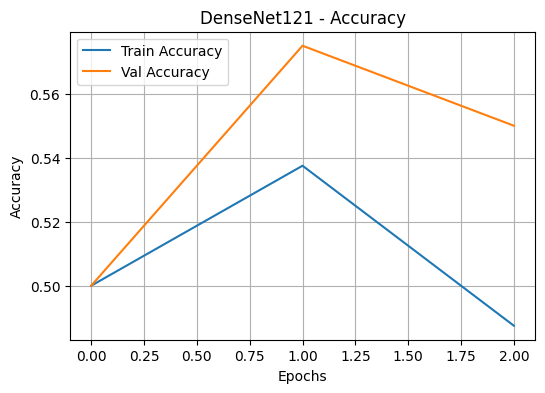

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🔍 DenseNet121 Prediction: Melanocytic nevus (77.62% confidence)

🚀 Training Model: Xception
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 9s/step - accuracy: 0.3984 - loss: 0.8037 - val_accuracy: 0.5750 - val_loss: 0.6945
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5733 - loss: 0.7046 - val_accuracy: 0.7000 - val_loss: 0.6310
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.6436 - loss: 0.6369 - val_accuracy: 0.7750 - val_loss: 0.5719
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


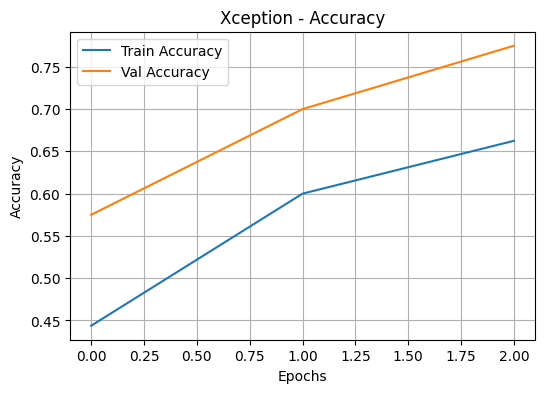

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔍 Xception Prediction: Melanocytic nevus (69.27% confidence)

📊 Model Comparison Table:

| Model          |   Train Accuracy (Final Epoch) |   Best Val Accuracy |   Precision |   Recall |   F1-Score |
|:---------------|-------------------------------:|--------------------:|------------:|---------:|-----------:|
| MobileNetV2    |                         0.6125 |               0.775 |      0.7757 |    0.775 |     0.7749 |
| EfficientNetB0 |                         0.475  |               0.5   |      0.25   |    0.5   |     0.3333 |
| ResNet50       |                         0.4688 |               0.5   |      0.25   |    0.5   |     0.3333 |
| DenseNet121    |                         0.4875 |               0.575 |      0.5595 |    0.55  |     0.5312 |
| Xception       |                         0.6625 |               0.775 |      0.8134 |    0.775 |     0.7679 |


In [ ]:
# import pandas as pd

# # Store metrics for each model
# results = []

# # ✅ LOOP THROUGH EACH MODEL
# for name, base in model_names.items():
#     print(f"\n🚀 Training Model: {name}")
#     model = build_model(base)
#     history = model.fit(train_data, validation_data=val_data, epochs=epochs)

#     # ✅ Evaluation
#     val_data.reset()
#     preds = model.predict(val_data)
#     y_pred = np.argmax(preds, axis=1)
#     y_true = val_data.classes
#     report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

#     # ✅ Store best val accuracy and prediction info
#     best_val_acc = max(history.history['val_accuracy'])
#     final_train_acc = history.history['accuracy'][-1]
#     results.append({
#         'Model': name,
#         'Train Accuracy (Final Epoch)': f"{final_train_acc:.4f}",
#         'Best Val Accuracy': f"{best_val_acc:.4f}",
#         'Precision': f"{report['weighted avg']['precision']:.4f}",
#         'Recall': f"{report['weighted avg']['recall']:.4f}",
#         'F1-Score': f"{report['weighted avg']['f1-score']:.4f}"
#     })

#     # ✅ Plot Accuracy
#     plt.figure(figsize=(6, 4))
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#     plt.title(f'{name} - Accuracy')
#     plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
#     plt.show()


# # ✅ Display Comparison Table
# results_df = pd.DataFrame(results)
# print("\n📊 Model Comparison Table:\n")
# print(results_df.to_markdown(index=False))  # If using a notebook, this gives a nice markdown table
